In [1]:
%reset -f
import os
import sys
import pathlib
# import argparse

sys.path.append('/home/psimmerl/mds_analysis')

import math
import numpy as np
import numba as nb
from math import ceil, floor

import pickle

# from src.helper_functions import alert, Table
# from src.histo_utilities import std_color_list as SCL

from src import CMS_lumi, tdrstyle
root_style = tdrstyle.setTDRStyle()

import ROOT as rt
from ROOT import RDataFrame
# from ROOT import TNtuple, TTree, TBranch, RDataFrame
from ROOT import TCanvas, TLatex, TLegend, TLine, TBox
from ROOT import TH1D, TH2D, TGraph, TGraphErrors, TGraphAsymmErrors

from src.helper_functions import alert, Table, weight_calc

# **************************** #
OUT_DIR = 'reports/weekly/2024-03-27'
LOCAL_OUT_DIR = '/home/psimmerl/mds_analysis'  # os.getcwd()

DATA_VERSION = '6'
LUMI = 23.02 * 1000
PI = rt.TMath.Pi()

LOCAL_DATA_DIR = '/home/psimmerl/mds_analysis/data'  # os.getcwd() + '/data/raw'
DATA_DIR = LOCAL_DATA_DIR#'TIER2' if 'caltech' in os.uname()[1] else 'LOCAL'
OUT_DIR = f'{LOCAL_OUT_DIR}/{OUT_DIR}'

pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

ROOT_ERROR_LEVEL = 1001  # rt.kInfo + 1
rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL

rt.EnableImplicitMT(4)
print('Enabled ROOT\'s implicit multithreading (sometimes causes a crash)')

SCL = [1, 2, 4, 8, 6, 28, 43, 7, 25, 36, 30, 40, 42, 49, 46, 38, 32, 800, 600, 900, 870, 840]

gc = []

# **************** #

TAG_CATEGORY = ('csccsc', 'cscdt')[0]
SIZE_VAR = TAG_CATEGORY[3:]


MET_CATEGORY = ('low', 'high')[0]
ABCD_DPHI = None
ABCD_SIZE = None

# **** #
# STANDARD CUT SELECTION
if 'csccsc' in TAG_CATEGORY:
    if 'low' in MET_CATEGORY:
        ABCD_DPHI = 2.90
        ABCD_SIZE = 137
    if 'high' in MET_CATEGORY:
        ABCD_DPHI = None
        ABCD_SIZE = None

if 'cscdt' in TAG_CATEGORY:
    if 'low' in MET_CATEGORY:
        ABCD_DPHI = 2.92
        ABCD_SIZE = 133
    if 'high' in MET_CATEGORY:
        ABCD_DPHI = 1.41
        ABCD_SIZE = 119

FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}_scs_{MET_CATEGORY}_rdf.root'
# FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}_scs_{MET_CATEGORY}_rdf.root'
# FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}OOT_scs_{MET_CATEGORY}_rdf.root'
FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}OOT_scs_{MET_CATEGORY}_rdf.root'

# # **** #
# # PEDROS DNN
# if 'csccsc' in TAG_CATEGORY:
#     if 'low' in MET_CATEGORY:
#         ABCD_DPHI = None
#         ABCD_SIZE = None
#     if 'high' in MET_CATEGORY:
#         ABCD_DPHI = None
#         ABCD_SIZE = None

# if 'cscdt' in TAG_CATEGORY:
#     if 'low' in MET_CATEGORY:
#         ABCD_DPHI = 2.64
#         ABCD_SIZE = 62
#     if 'high' in MET_CATEGORY:
#         ABCD_DPHI = 2.53
#         ABCD_SIZE = 99

# FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}_pedro_{MET_CATEGORY}_rdf.root'
# FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}_pedro_{MET_CATEGORY}_rdf.root'
# # FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}OOT_pedro_{MET_CATEGORY}_rdf.root'
# # FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}OOT_pedro_{MET_CATEGORY}_rdf.root'

# # **** #
# # LOO Optimized
# if 'csccsc' in TAG_CATEGORY:
#     if 'low' in MET_CATEGORY:
#         ABCD_DPHI = None
#         ABCD_SIZE = None
#     if 'high' in MET_CATEGORY:
#         ABCD_DPHI = None
#         ABCD_SIZE = None

# if 'cscdt' in TAG_CATEGORY:
#     if 'low' in MET_CATEGORY:
#         ABCD_DPHI = 2.302329596368428#3.0296909126269442#2.1904278554055794
#         ABCD_SIZE = 72.44897959183673#107.14285714285714#107.14285714285714
#     if 'high' in MET_CATEGORY:
#         ABCD_DPHI = 2.526133078294125
#         ABCD_SIZE = 98.9795918367347

# FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}_loo_{MET_CATEGORY}_rdf.root'
# FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}_loo_{MET_CATEGORY}_rdf.root'
# # FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}OOT_loo_{MET_CATEGORY}_rdf.root'
# # FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}OOT_loo_{MET_CATEGORY}_rdf.root'

# **************** #
print(f'{TAG_CATEGORY=}')
print(f'{SIZE_VAR=}')
print('')

print(f'{MET_CATEGORY=}')
print(f'{ABCD_DPHI=}')
print(f'{ABCD_SIZE=}')
print('')

print(f'{FN_MC=}')
print(f'{FN_R3=}')
print(f'{OUT_DIR=}')
print('')

rdfs = {
    'mc' : RDataFrame('MuonSystem_flat', FN_MC),
    'r3' : RDataFrame('MuonSystem_flat', FN_R3),
}

print('Events Read:')
for key, rdf in rdfs.items():
    if SIZE_VAR == 'csc':
        if MET_CATEGORY == 'low':
            rdf = rdf.Filter('tag_dPhi > 1.0')
        else:
            raise Warning('probably wont to close')
        # rdf = rdf.Filter('tag_dR > 1.5')
        rdf = rdf.Alias('tag_size', 'csc1Size')
        rdf = rdf.Alias('tag_ctau', 'csc1CTau')

        rdf = rdf.Define('tag_dT', 'abs(csc0TimeWeighted - csc1TimeWeighted)')
        # rdf = rdf.Define('tag_dT', 'csc0TimeWeighted - csc1TimeWeighted')
        rdf = rdf.Filter('tag_dT < 5')
    elif SIZE_VAR == 'dt':
        rdf = rdf.Filter('tag_dPhi > 0.4')
        rdf = rdf.Alias('tag_size', 'dtSize')
        rdf = rdf.Alias('tag_ctau', 'dtCTau')

    count, weight = rdf.Count().GetValue(), rdf.Sum('weight').GetValue()
    print(f'  {key} = {count:,} ({weight:,.2f})')

    rdfs[key] = rdf


Welcome to JupyROOT 6.30/02
Enabled ROOT's implicit multithreading (sometimes causes a crash)
TAG_CATEGORY='csccsc'
SIZE_VAR='csc'

MET_CATEGORY='low'
ABCD_DPHI=2.9
ABCD_SIZE=137

FN_MC='/home/psimmerl/mds_analysis/data/processed/mc_csccsc_scs_low_rdf.root'
FN_R3='/home/psimmerl/mds_analysis/data/processed/r3_csccscOOT_scs_low_rdf.root'
OUT_DIR='/home/psimmerl/mds_analysis/reports/weekly/2024-03-27'

Events Read:
  mc = 2,314 (1,397.86)
  r3 = 1,730 (1,730.00)


In [2]:
if 'OOT' not in FN_R3:
    raise Warning('data is not OOT!')

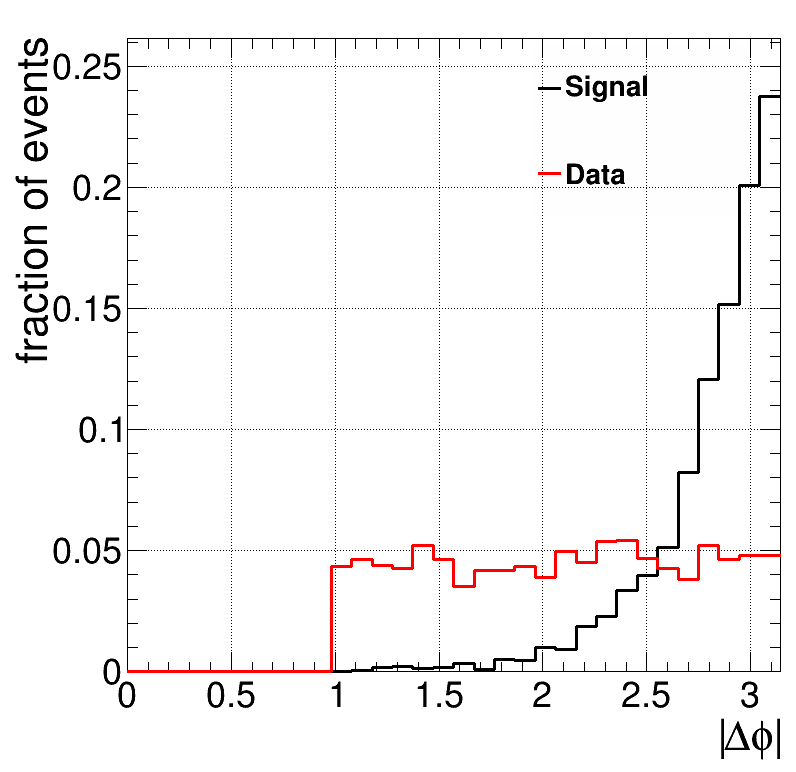

In [3]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()
# canvas.SetLogy()

legend = TLegend(0.67, 0.72, 0.94, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0.0)#0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.15)

xv = 'tag_dPhi'
txy_label = f';|#Delta#phi|;fraction of events'
form =(txy_label,32,0,np.pi)

# xv = 'csc0Phi'
# txy_label = f';#phi_{{var}};fraction of events'
# form =(txy_label,32,0,np.pi)
# **** #

h1 = rdfs['mc'].Histo1D(('Signal',*form),xv,).GetValue()
h2 = rdfs['r3'].Histo1D(('Data',*form),xv,).GetValue()

hhs = [h1,h2]
# hmax = max([h.GetMaximum() for h in hhs])
hmax = max([h.GetMaximum() / h.Integral() if h.Integral() else 0 for h in hhs])
for ih, hh in enumerate(hhs):
    nev = hh.Integral()
    if hmax < 1 and nev:
        hh.Scale(1/hh.Integral())
    hh.SetMinimum(0)
    hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    hh.Draw('hist same')
    legend.AddEntry(hh, hh.GetName(), 'L')


legend.Draw()
canvas.Draw()


# ABCD Optimization


In [4]:
# sizes = np.linspace(50,150,101) #if ABCD_SIZE is None else np.array([ABCD_SIZE])
# dphis = np.linspace(0.4,np.pi,50) #if ABCD_DPHI is None else np.array([ABCD_DPHI])
''' CSC-DT
s2b   = 944.8692401312594
dphi  = 2.302329596368428
size  = 72.0
a_mc  = 668.1234470313939
ap_r3 = 0.5
'''

min_dphi = min([rdf.Min('tag_dPhi').GetValue() for k, rdf in rdfs.items()])
if TAG_CATEGORY == 'csc' and MET_CATEGORY == 'low':
    min_dphi = 1
elif TAG_CATEGORY == 'csc' and MET_CATEGORY == 'high':
    min_dphi = 0
elif TAG_CATEGORY == 'dt' and MET_CATEGORY == 'low':
    min_dphi = 0.4
elif TAG_CATEGORY == 'dt' and MET_CATEGORY == 'high':
    min_dphi = 0.4


# sizes = np.linspace(50,150,101)
# dphis = np.linspace(2/3*np.pi,np.pi,50)
# dphis = np.linspace(min_dphi,np.pi,50)

sizes = np.arange(50,150+1,1)
# dphis = np.arange(1.00,3.15+0.05,0.05)
dphis = np.arange(min_dphi,3.15+0.05,0.05)
''' CSC-DT
s2b   = 955.1209859554683
dphi  = 2.2653661311599866
size  = 72.0
a_mc  = 675.3725260226929
ap_r3 = 0.5
'''

if 'high' in FN_MC:
    a_mc = [ [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    b_mc = [ [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    c_mc = [ [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    d_mc = [ [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]

    a_r3 = [ [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    b_r3 = [ [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    c_r3 = [ [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    d_r3 = [ [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
else:
    a_mc = [ [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    b_mc = [ [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    c_mc = [ [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    d_mc = [ [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]

    a_r3 = [ [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    b_r3 = [ [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    c_r3 = [ [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    d_r3 = [ [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]

a_mc = np.array([ [xx.GetValue() for xx in x] for x in a_mc ])
b_mc = np.array([ [xx.GetValue() for xx in x] for x in b_mc ])
c_mc = np.array([ [xx.GetValue() for xx in x] for x in c_mc ])
d_mc = np.array([ [xx.GetValue() for xx in x] for x in d_mc ])

a_r3 = np.array([ [xx.GetValue() for xx in x] for x in a_r3 ])
b_r3 = np.array([ [xx.GetValue() for xx in x] for x in b_r3 ])
c_r3 = np.array([ [xx.GetValue() for xx in x] for x in c_r3 ])
d_r3 = np.array([ [xx.GetValue() for xx in x] for x in d_r3 ])

ap_mc = np.divide(b_mc*d_mc, c_mc, where=c_mc>0, out=np.zeros_like(a_mc))
ap_r3 = np.divide(b_r3*d_r3, c_r3, where=c_r3>0, out=np.zeros_like(a_r3))

In [5]:

# There has to be signal and data in each of the 4 bins for the ABCD method to work
cond = ((a_mc>0) & (b_mc>0) & (c_mc>0) & (d_mc>0)) & \
        ((ap_r3>0) & (b_r3>0) & (c_r3>0) & (d_r3>0))

# Here we add a condition that the predicted value must be within 2 sigma of the actual value
ae_r3 = np.sqrt(a_r3)
ape_r3 = ap_r3 * np.sqrt(
    np.divide(1,b_r3, where=cond, out=np.ones_like(b_r3)) +
    np.divide(1,c_r3, where=cond, out=np.ones_like(c_r3)) +
    np.divide(1,d_r3, where=cond, out=np.ones_like(d_r3))
)

cond = cond & (np.divide(np.abs(a_r3-ap_r3),np.sqrt(ae_r3**2 + ape_r3**2), where=cond, out=999*np.ones_like(a_r3))<1)
# cond = cond & (a_mc>700)

####

s2bs = np.divide(a_mc, np.sqrt(ap_r3), where=cond, out=np.zeros_like(a_mc))
# s2bs = np.divide(a_mc, ap_r3, where=cond, out=np.zeros_like(a_mc))

idx_s2b = np.unravel_index(np.argmax(s2bs), s2bs.shape)

print(f's2b   = {s2bs[idx_s2b]}')
# print(f'dphi  = {dphis[idx_s2b[1]]}')
# print(f'size  = {sizes[idx_s2b[0]]}')
print(f'dphi  = {dphis[idx_s2b[0]]}')
print(f'size  = {sizes[idx_s2b[1]]}')
print(f'a_mc  = {a_mc[idx_s2b]}')
print(f'ap_r3 = {ap_r3[idx_s2b]}')

ABCD_DPHI = dphis[idx_s2b[0]]
ABCD_SIZE = sizes[idx_s2b[1]]

s2b   = 177.9959411275875
dphi  = 2.7000896453857437
size  = 142
a_mc  = 650.6048394690879
ap_r3 = 13.36024371667936


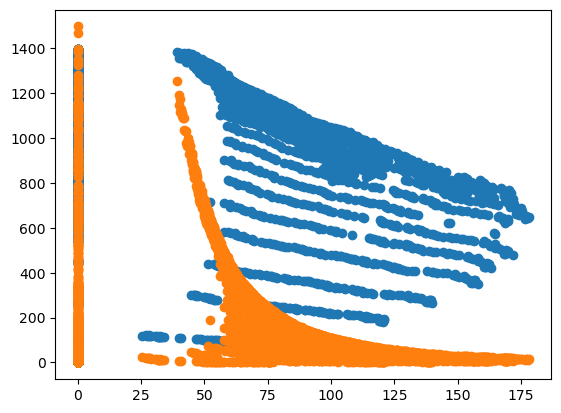

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.scatter(s2bs,a_mc)
plt.scatter(s2bs,ap_r3)


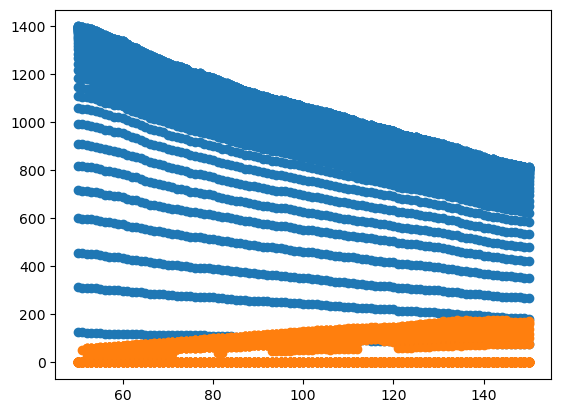

In [7]:
plt.scatter(np.repeat(sizes.reshape(1,-1),a_mc.shape[0],0),a_mc)
# plt.scatter(np.repeat(sizes.reshape(1,-1),a_mc.shape[0],0),ap_r3*100)
plt.scatter(np.repeat(sizes.reshape(1,-1),a_mc.shape[0],0),s2bs)


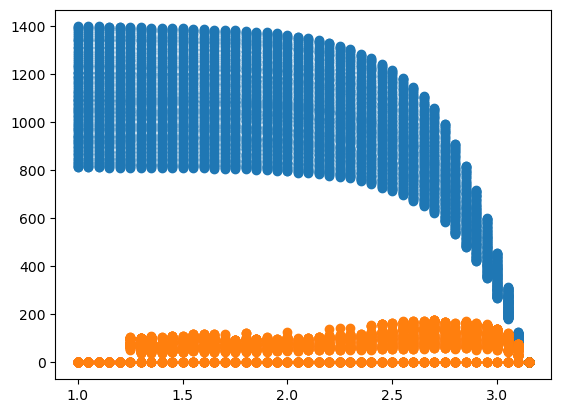

In [8]:
plt.scatter(np.repeat(dphis.reshape(-1,1),a_mc.shape[1],1),a_mc)
# plt.scatter(np.repeat(dphis.reshape(-1,1),a_mc.shape[1],1),ap_r3*100)
plt.scatter(np.repeat(dphis.reshape(-1,1),a_mc.shape[1],1),s2bs)


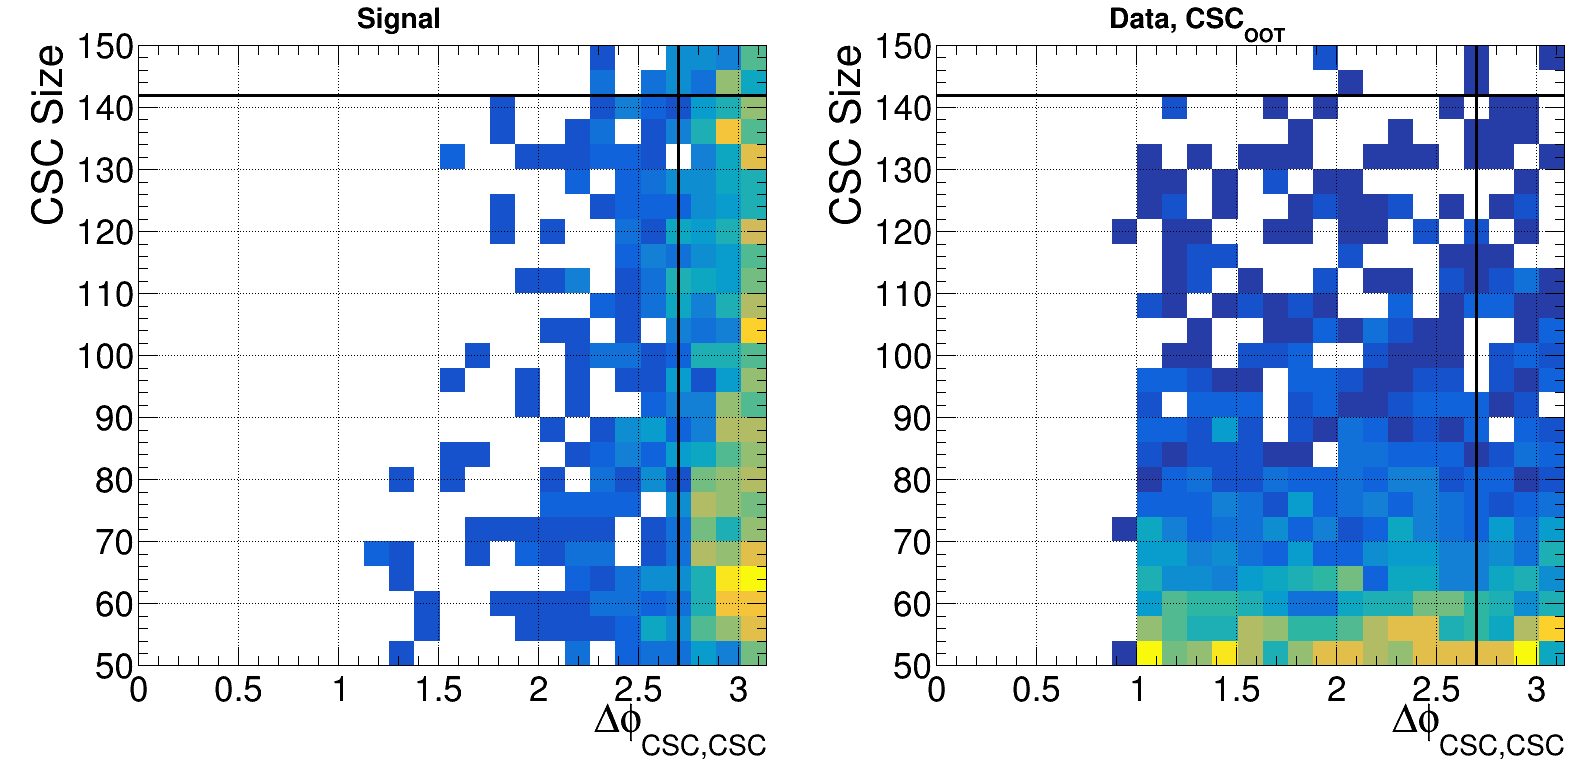

In [9]:
canvas = TCanvas('','',2*800,800)
canvas.Divide(2,1)

dopt = ('col','box')[0]
nb = 25

form = ('',f';#Delta#phi_{{CSC,{SIZE_VAR.upper()}}};{SIZE_VAR.upper()} Size;count',nb,0,np.pi,nb,50,150)

dphi_line = TLine(ABCD_DPHI,50,ABCD_DPHI,150)
size_line = TLine(0,ABCD_SIZE,np.pi,ABCD_SIZE)
dphi_line.SetLineWidth(3)
size_line.SetLineWidth(3)

if 'high' in FN_R3:
    sr_box = TBox(0, ABCD_SIZE, ABCD_DPHI, 150)
else:# 'low' in FN_R3:
    sr_box = TBox(ABCD_DPHI, ABCD_SIZE, np.pi, 150)
sr_box.SetFillColor(rt.kBlack)

latex = TLatex()
latex.SetTextAlign(23)
latex.SetTextSize(0.04)

canvas.cd(1).SetGrid()
h_mc = rdfs['mc'].Histo2D(form,'tag_dPhi','tag_size').GetValue()
h_mc.Draw(dopt)

dphi_line.Draw()
size_line.Draw()
latex.DrawLatexNDC(0.5, 1, 'Signal'+(f', {SIZE_VAR.upper()}_{{OOT}}' if 'OOT' in FN_MC else ''))

canvas.cd(2).SetGrid()
h_r3 = rdfs['r3'].Histo2D(form,'tag_dPhi','tag_size').GetValue()
h_r3.Draw(dopt)

dphi_line.Draw()
size_line.Draw()
latex.DrawLatexNDC(0.5, 1, 'Data'+(f', {SIZE_VAR.upper()}_{{OOT}}' if 'OOT' in FN_R3 else ''))
if 'OOT' not in FN_R3:
    sr_box.Draw()

canvas.Draw()

#  Size Closure

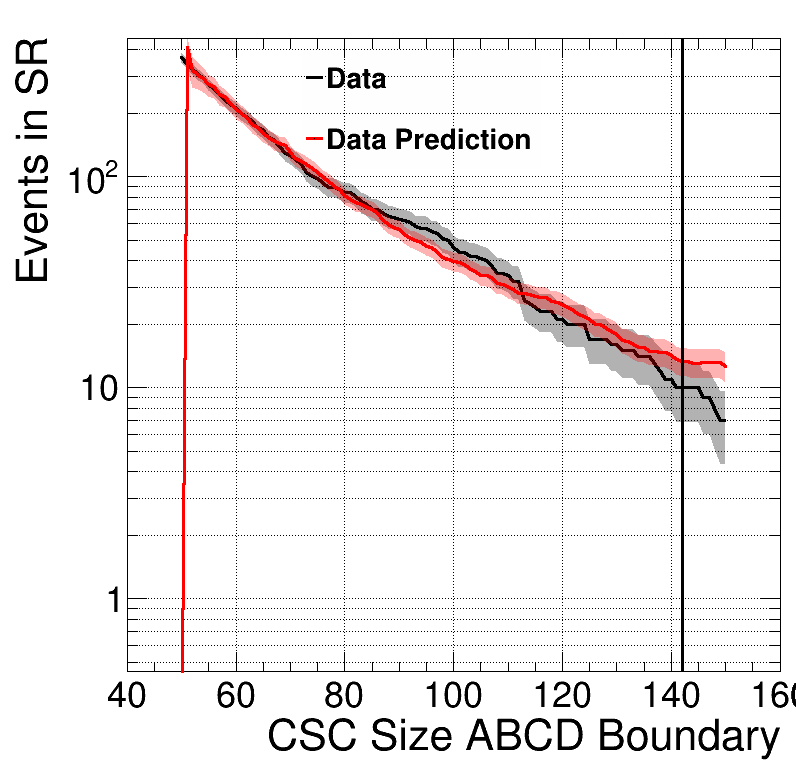

In [14]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()
canvas.SetLogy()

legend = TLegend(0.38, 0.78, 0.68, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0)#0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.1)

# sizes = np.linspace(50,150,100)

if 'high' in FN_MC:
    a_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]
    b_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    c_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    d_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]

    a_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]
    b_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    c_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    d_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]
else:
    a_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]
    b_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    c_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    d_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]

    a_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]
    b_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    c_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    d_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]

a_mc = np.array([x.GetValue() for x in a_mc])
b_mc = np.array([x.GetValue() for x in b_mc])
c_mc = np.array([x.GetValue() for x in c_mc])
d_mc = np.array([x.GetValue() for x in d_mc])

a_r3 = np.array([x.GetValue() for x in a_r3])
b_r3 = np.array([x.GetValue() for x in b_r3])
c_r3 = np.array([x.GetValue() for x in c_r3])
d_r3 = np.array([x.GetValue() for x in d_r3])

ap_mc = np.array([b*d/c if c else -1 for b,c,d in zip(b_mc,c_mc,d_mc)])
ap_r3 = np.array([b*d/c if c else -1 for b,c,d in zip(b_r3,c_r3,d_r3)])

ae_mc = np.sqrt(a_mc)
ae_r3 = np.sqrt(a_r3)
ape_mc = np.array([a*(1/b+1/c+1/d)**(1/2) if b and c and d else 0 for a,b,c,d in zip(ap_mc,b_mc,c_mc,d_mc)])
ape_r3 = np.array([a*(1/b+1/c+1/d)**(1/2) if b and c and d else 0 for a,b,c,d in zip(ap_r3,b_r3,c_r3,d_r3)])

# **** #
xx = sizes
xlabel, ylabel = f'{SIZE_VAR.upper()} Size ABCD Boundary', 'Events in SR'

values = [[a_r3,ae_r3],[ap_r3,ape_r3]]#,[a_mc,ae_mc],[ap_mc,ape_mc]]
names = ['Data', 'Data Prediction']#,'Signal', 'Signal Prediction',]

hmin, hmax = 0, 1.1*max([max(v[0]) for v in values])
for igr, (vv, ve) in enumerate(values):
    # if 'median' in ylabel.lower():
    #     yy = np.array([[np.median(v),np.median(v)-np.percentile(v,25),np.percentile(v,75)-np.median(v)] if len(v) else [0,0,0] for v in val])
    # elif 'mean' in ylabel.lower():
    #     yy = np.array([[v.mean(),v.mean()-np.percentile(v,25),np.percentile(v,75)-v.mean()] if len(v) else [0,0,0] for v in val])
    gr = TGraphErrors(len(xx),xx*1.,vv*1.,xx*0.,ve*1.)
    gr.GetXaxis().SetLimits(np.min(xx), np.max(xx))
    gr.SetMinimum(hmin)
    gr.SetMaximum(hmax)
    gr.SetName(names[igr])
    gr.GetXaxis().SetTitle(xlabel)
    gr.GetYaxis().SetTitle(ylabel)

    gr.SetLineWidth(3)
    gr.SetLineColor(SCL[igr])
    # gr.SetLineColor(SCL[0 if 'Signal' in names[igr] else 1])
    gr.SetLineStyle(rt.kDashed if '<' in names[igr] else rt.kSolid)
    gr.SetFillColorAlpha(gr.GetLineColor(), 0.3)
    gr.Draw(('' if igr else 'A')+' L3')
    legend.AddEntry(gr,gr.GetName(),'LP')
    gc.append(gr)

size_line = TLine(ABCD_SIZE,0,ABCD_SIZE,hmax)
size_line.Draw()
size_line.SetLineWidth(3)

legend.Draw()
canvas.Draw()


In [11]:
# table
idx0 = np.argwhere(sizes == ABCD_SIZE)[0][0]
print(r'\begin{center}')
print(r'\begin{tabular}{c|cccc|c}')
print(r'    \hline')
print(f'    \\textbf{{{SIZE_VAR.upper()} Size}} & D & C & B & A & $A_{{pred}}=\\frac{{B \\cdot D}}{{C}}$ \\\\')
print(r'    \hline\hline')
for i in range(idx0-3, idx0+4):
    print(f'    {sizes[i]:.0f} & {d_r3[i]:.0f} & {c_r3[i]:.0f} & {b_r3[i]:.0f} & {a_r3[i]:.0f} ($\pm$ {a_r3[i]**0.5:.2f}) & {ap_r3[i]:.2f} ($\pm$ {ape_r3[i]:.2f}) \\\\')
    if i-idx0 in (-1, 0):
        print(r'    \hline')
print(r'\end{tabular}')
print(r'\end{center}')

\begin{center}
\begin{tabular}{c|cccc|c}
    \hline
    \textbf{CSC Size} & D & C & B & A & $A_{pred}=\frac{B \cdot D}{C}$ \\
    \hline\hline
    139 & 54 & 1308 & 357 & 11 ($\pm$ 3.32) & 14.74 ($\pm$ 2.19) \\
    140 & 52 & 1310 & 357 & 11 ($\pm$ 3.32) & 14.17 ($\pm$ 2.14) \\
    141 & 50 & 1312 & 358 & 10 ($\pm$ 3.16) & 13.64 ($\pm$ 2.09) \\
    \hline
    142 & 49 & 1313 & 358 & 10 ($\pm$ 3.16) & 13.36 ($\pm$ 2.07) \\
    \hline
    143 & 49 & 1313 & 358 & 10 ($\pm$ 3.16) & 13.36 ($\pm$ 2.07) \\
    144 & 48 & 1314 & 358 & 10 ($\pm$ 3.16) & 13.08 ($\pm$ 2.04) \\
    145 & 48 & 1314 & 358 & 10 ($\pm$ 3.16) & 13.08 ($\pm$ 2.04) \\
\end{tabular}
\end{center}


# deltaPhi Closure

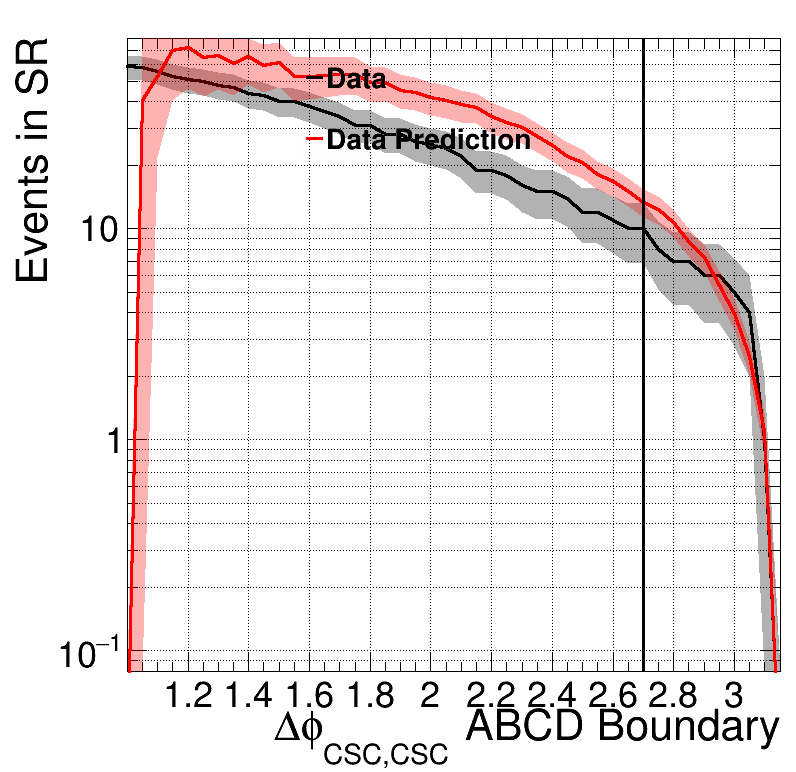

In [15]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()
canvas.SetLogy()

legend = TLegend(0.38, 0.78, 0.68, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0)#0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.1)

# dphis = np.linspace(0.4,np.pi,100)

if 'high' in FN_MC:
    a_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]
    b_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    c_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    d_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]

    a_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]
    b_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    c_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    d_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]
else:
    a_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]
    b_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    c_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    d_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]

    a_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]
    b_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    c_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    d_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]

a_mc = np.array([x.GetValue() for x in a_mc])
b_mc = np.array([x.GetValue() for x in b_mc])
c_mc = np.array([x.GetValue() for x in c_mc])
d_mc = np.array([x.GetValue() for x in d_mc])

a_r3 = np.array([x.GetValue() for x in a_r3])
b_r3 = np.array([x.GetValue() for x in b_r3])
c_r3 = np.array([x.GetValue() for x in c_r3])
d_r3 = np.array([x.GetValue() for x in d_r3])

ap_mc = np.array([b*d/c if c else -1 for b,c,d in zip(b_mc,c_mc,d_mc)])
ap_r3 = np.array([b*d/c if c else -1 for b,c,d in zip(b_r3,c_r3,d_r3)])

ae_mc = np.sqrt(a_mc)
ae_r3 = np.sqrt(a_r3)
ape_mc = np.array([a*(1/b+1/c+1/d)**(1/2) if b and c and d else 0 for a,b,c,d in zip(ap_mc,b_mc,c_mc,d_mc)])
ape_r3 = np.array([a*(1/b+1/c+1/d)**(1/2) if b and c and d else 0 for a,b,c,d in zip(ap_r3,b_r3,c_r3,d_r3)])

# **** #
xx = dphis
xlabel, ylabel = f'#Delta#phi_{{CSC,{SIZE_VAR.upper()}}} ABCD Boundary', 'Events in SR'

values = [[a_r3,ae_r3],[ap_r3,ape_r3]]#,[a_mc,ae_mc],[ap_mc,ape_mc]]
names = ['Data', 'Data Prediction']#,'Signal', 'Signal Prediction',]

hmin, hmax = 0, 1.1*max([max(v[0]) for v in values])
for igr, (vv, ve) in enumerate(values):
    # if 'median' in ylabel.lower():
    #     yy = np.array([[np.median(v),np.median(v)-np.percentile(v,25),np.percentile(v,75)-np.median(v)] if len(v) else [0,0,0] for v in val])
    # elif 'mean' in ylabel.lower():
    #     yy = np.array([[v.mean(),v.mean()-np.percentile(v,25),np.percentile(v,75)-v.mean()] if len(v) else [0,0,0] for v in val])
    gr = TGraphErrors(len(xx),xx*1.,vv*1.,xx*0.,ve*1.)
    gr.GetXaxis().SetLimits(np.min(xx), np.max(xx))
    gr.SetMinimum(hmin)
    gr.SetMaximum(hmax)
    gr.SetName(names[igr])
    gr.GetXaxis().SetTitle(xlabel)
    gr.GetYaxis().SetTitle(ylabel)

    gr.SetLineWidth(3)
    gr.SetLineColor(SCL[igr])
    # gr.SetLineColor(SCL[0 if 'Signal' in names[igr] else 1])
    gr.SetLineStyle(rt.kDashed if '<' in names[igr] else rt.kSolid)
    gr.SetFillColorAlpha(gr.GetLineColor(), 0.3)
    gr.Draw(('' if igr else 'A')+' L3')
    legend.AddEntry(gr,gr.GetName(),'LP')
    gc.append(gr)

dphi_line = TLine(ABCD_DPHI,0,ABCD_DPHI,hmax)
dphi_line.Draw()
dphi_line.SetLineWidth(3)

legend.Draw()
canvas.Draw()


In [13]:
# table
idx0 = np.argwhere(dphis == ABCD_DPHI)[0][0]
print(r'\begin{center}')
print(r'\begin{tabular}{c|cccc|c}')
print(r'    \hline')
print(f'    $\\mathbf{{|\\Delta\\phi_{{CSC,{SIZE_VAR.upper()}}}}}$ & D & C & B & A & $A_{{pred}}=\\frac{{B \\cdot D}}{{C}}$ \\\\')
print(r'    \hline\hline')
for i in range(idx0-3, idx0+4):
    print(f'    {dphis[i]:.2f} & {d_r3[i]:.0f} & {c_r3[i]:.0f} & {b_r3[i]:.0f} & {a_r3[i]:.0f} ($\pm$ {a_r3[i]**0.5:.2f}) & {ap_r3[i]:.2f} ($\pm$ {ape_r3[i]:.2f}) \\\\')
    if i-idx0 in (-1, 0):
        print(r'    \hline')
print(r'\end{tabular}')
print(r'\end{center}')

\begin{center}
\begin{tabular}{c|cccc|c}
    \hline
    $\mathbf{|\Delta\phi_{CSC,CSC}}$ & D & C & B & A & $A_{pred}=\frac{B \cdot D}{C}$ \\
    \hline\hline
    2.55 & 47 & 1206 & 465 & 12 ($\pm$ 3.46) & 18.12 ($\pm$ 2.82) \\
    2.60 & 48 & 1238 & 433 & 11 ($\pm$ 3.32) & 16.79 ($\pm$ 2.60) \\
    2.65 & 49 & 1279 & 392 & 10 ($\pm$ 3.16) & 15.02 ($\pm$ 2.31) \\
    \hline
    2.70 & 49 & 1313 & 358 & 10 ($\pm$ 3.16) & 13.36 ($\pm$ 2.07) \\
    \hline
    2.75 & 51 & 1344 & 327 & 8 ($\pm$ 2.83) & 12.41 ($\pm$ 1.90) \\
    2.80 & 52 & 1385 & 286 & 7 ($\pm$ 2.65) & 10.74 ($\pm$ 1.64) \\
    2.85 & 52 & 1433 & 238 & 7 ($\pm$ 2.65) & 8.64 ($\pm$ 1.34) \\
\end{tabular}
\end{center}
